## Walking through the steps to calculate the centroid of a single 3D label

First, load the cellpose segmentation file

In [1]:
import numpy as np
import napari

segmenations_path = './220624_Fix_Flvw_Emb_PI_Utr647_E02-10X-Z01_downsample_log_seg-cyto.npy'
segmentations = np.load(segmenations_path, allow_pickle=True).item()

From the docs (https://cellpose.readthedocs.io/_/downloads/en/latest/pdf/) segmentations is a dictionary object with the following fields:
 - filename : filename of image
 - img : image with chosen channels (nchan x Ly x Lx) (if not multiplane)
 - masks : each pixel in the image is assigned to an ROI (0 = NO ROI; 1,2,. . . = ROI labels)
 - colors : colors for ROIs
 - outlines : outlines of ROIs (0 = NO outline; 1,2,. . . = outline labels)
 - chan_choose : channels that you chose in GUI (0=gray/none, 1=red, 2=green, 3=blue)
 - ismanual : element k = whether or not mask k was manually drawn or computed by the cellpose algorithm
 - flows [flows[0] is XY flow in RGB, flows[1] is the cell probability in range 0-255 instead of 0.0 to 1.0, flows[2]
is Z flow in range 0-255 (if it exists, otherwise zeros),] flows[3] is [dY, dX, cellprob] (or [dZ, dY, dX,
cellprob] for 3D), flows[4] is pixel destinations (for internal use)
 - est_diam : estimated diameter (if run on command line)
 - zdraw : for each mask, which planes were manually labelled (planes in between manually drawn have interpolated
ROIs)

#### get the masks out of the segmentations dictionary

In [2]:
all_masks = segmentations['masks']
print(f'all mask shape is {all_masks.shape}')

all mask shape is (98, 256, 256)


In [3]:
%gui qt 
viewer = napari.Viewer()

/Users/bementmbp/opt/anaconda3/envs/napari_apoc/lib/python3.9/site-packages/napari_tools_menu/__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


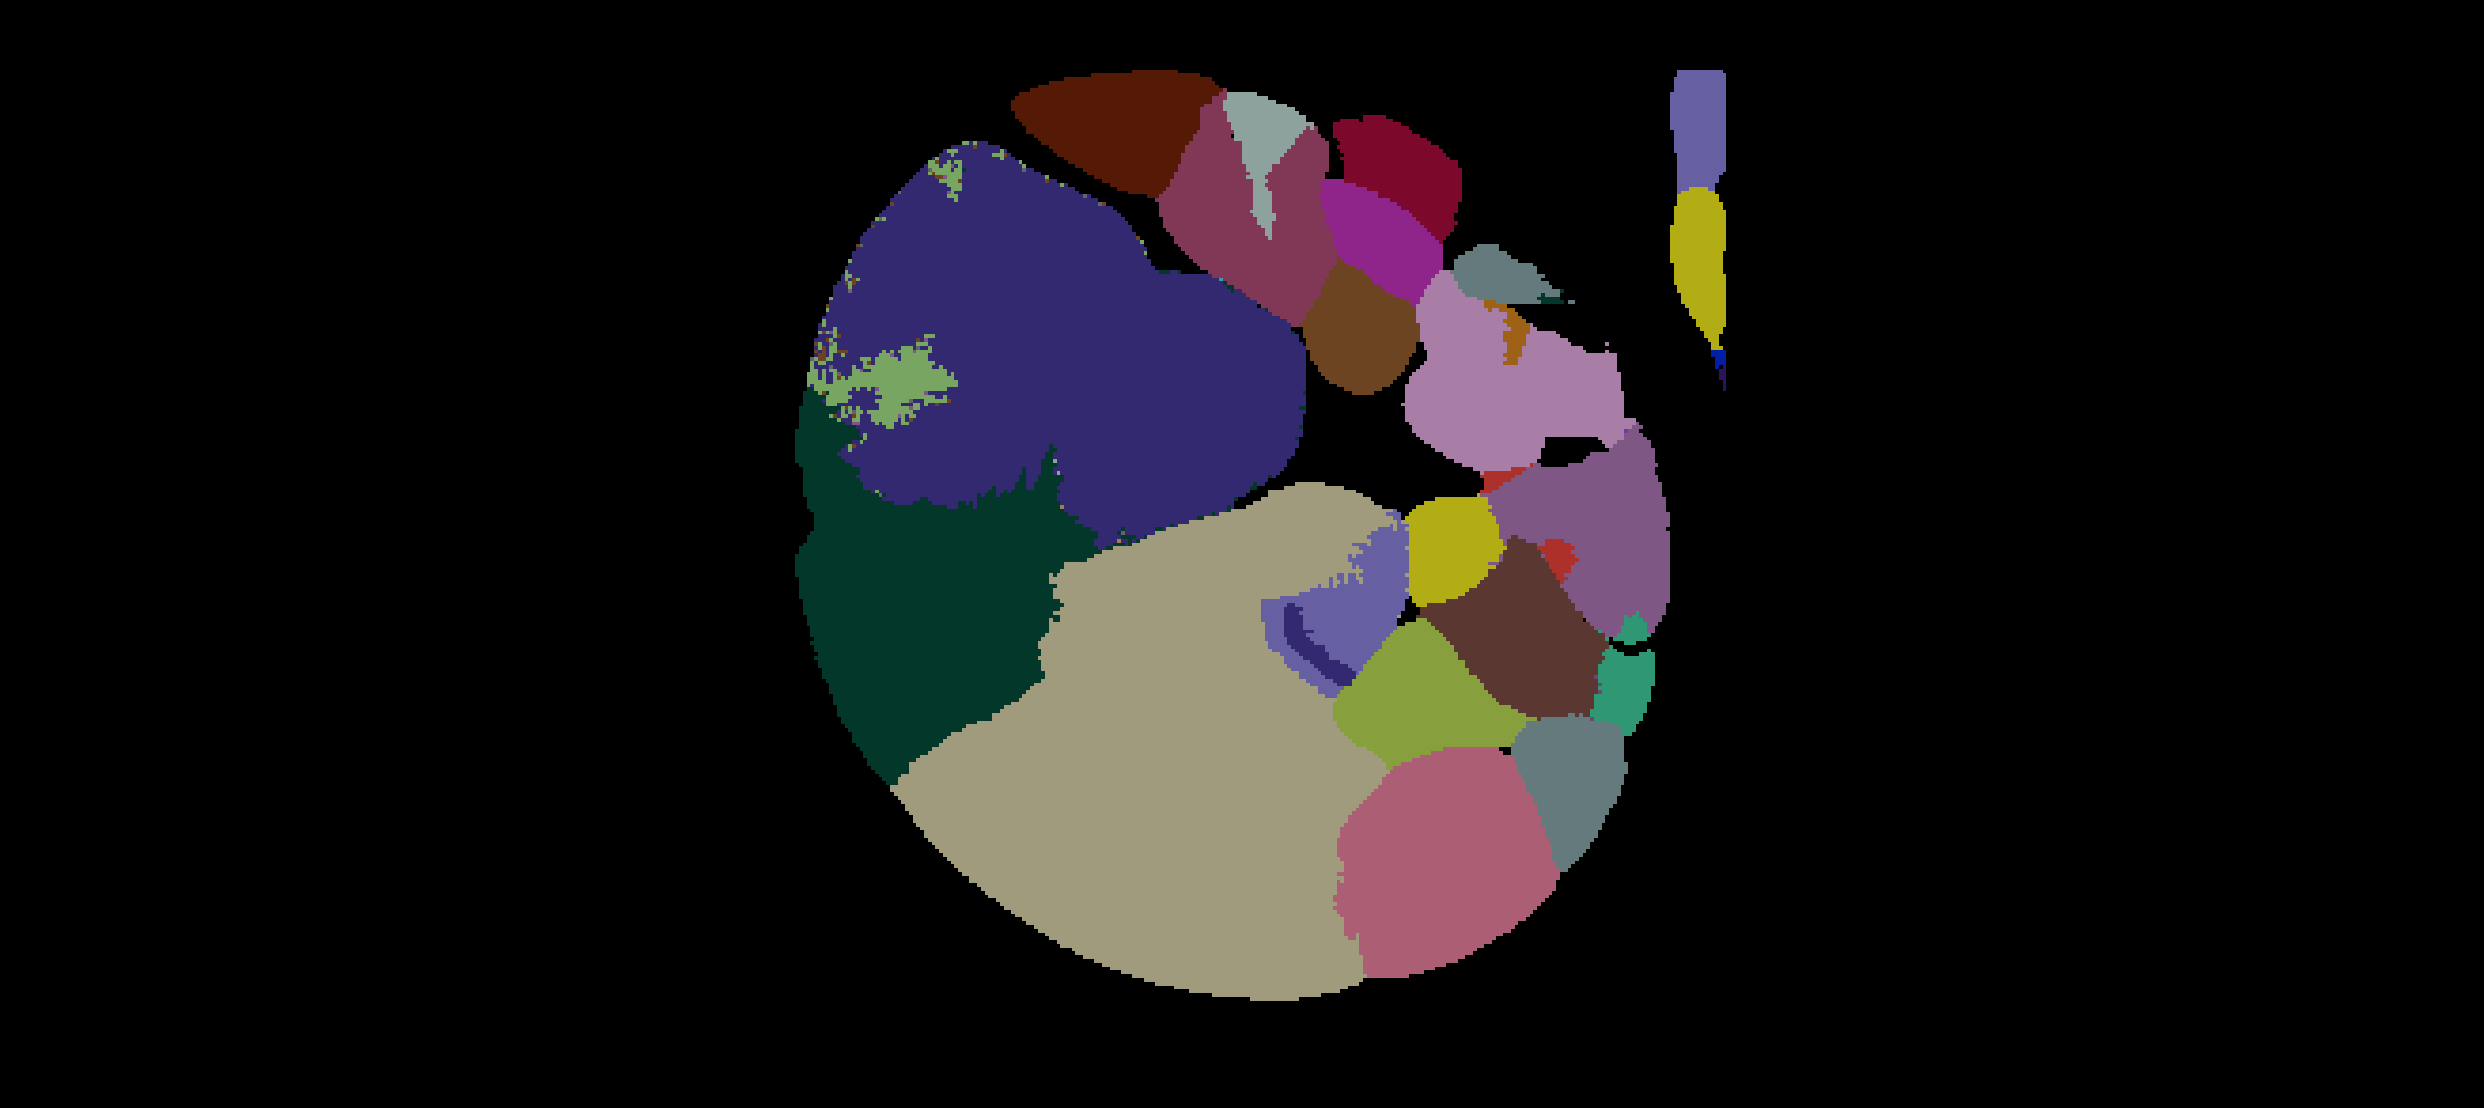

In [6]:
from napari.utils.notebook_display import nbscreenshot
viewer.add_labels(all_masks, name='all_masks')
nbscreenshot(viewer, canvas_only=True)

### Isolate a single mask that looks nice to work with

mask shape is (98, 256, 256)


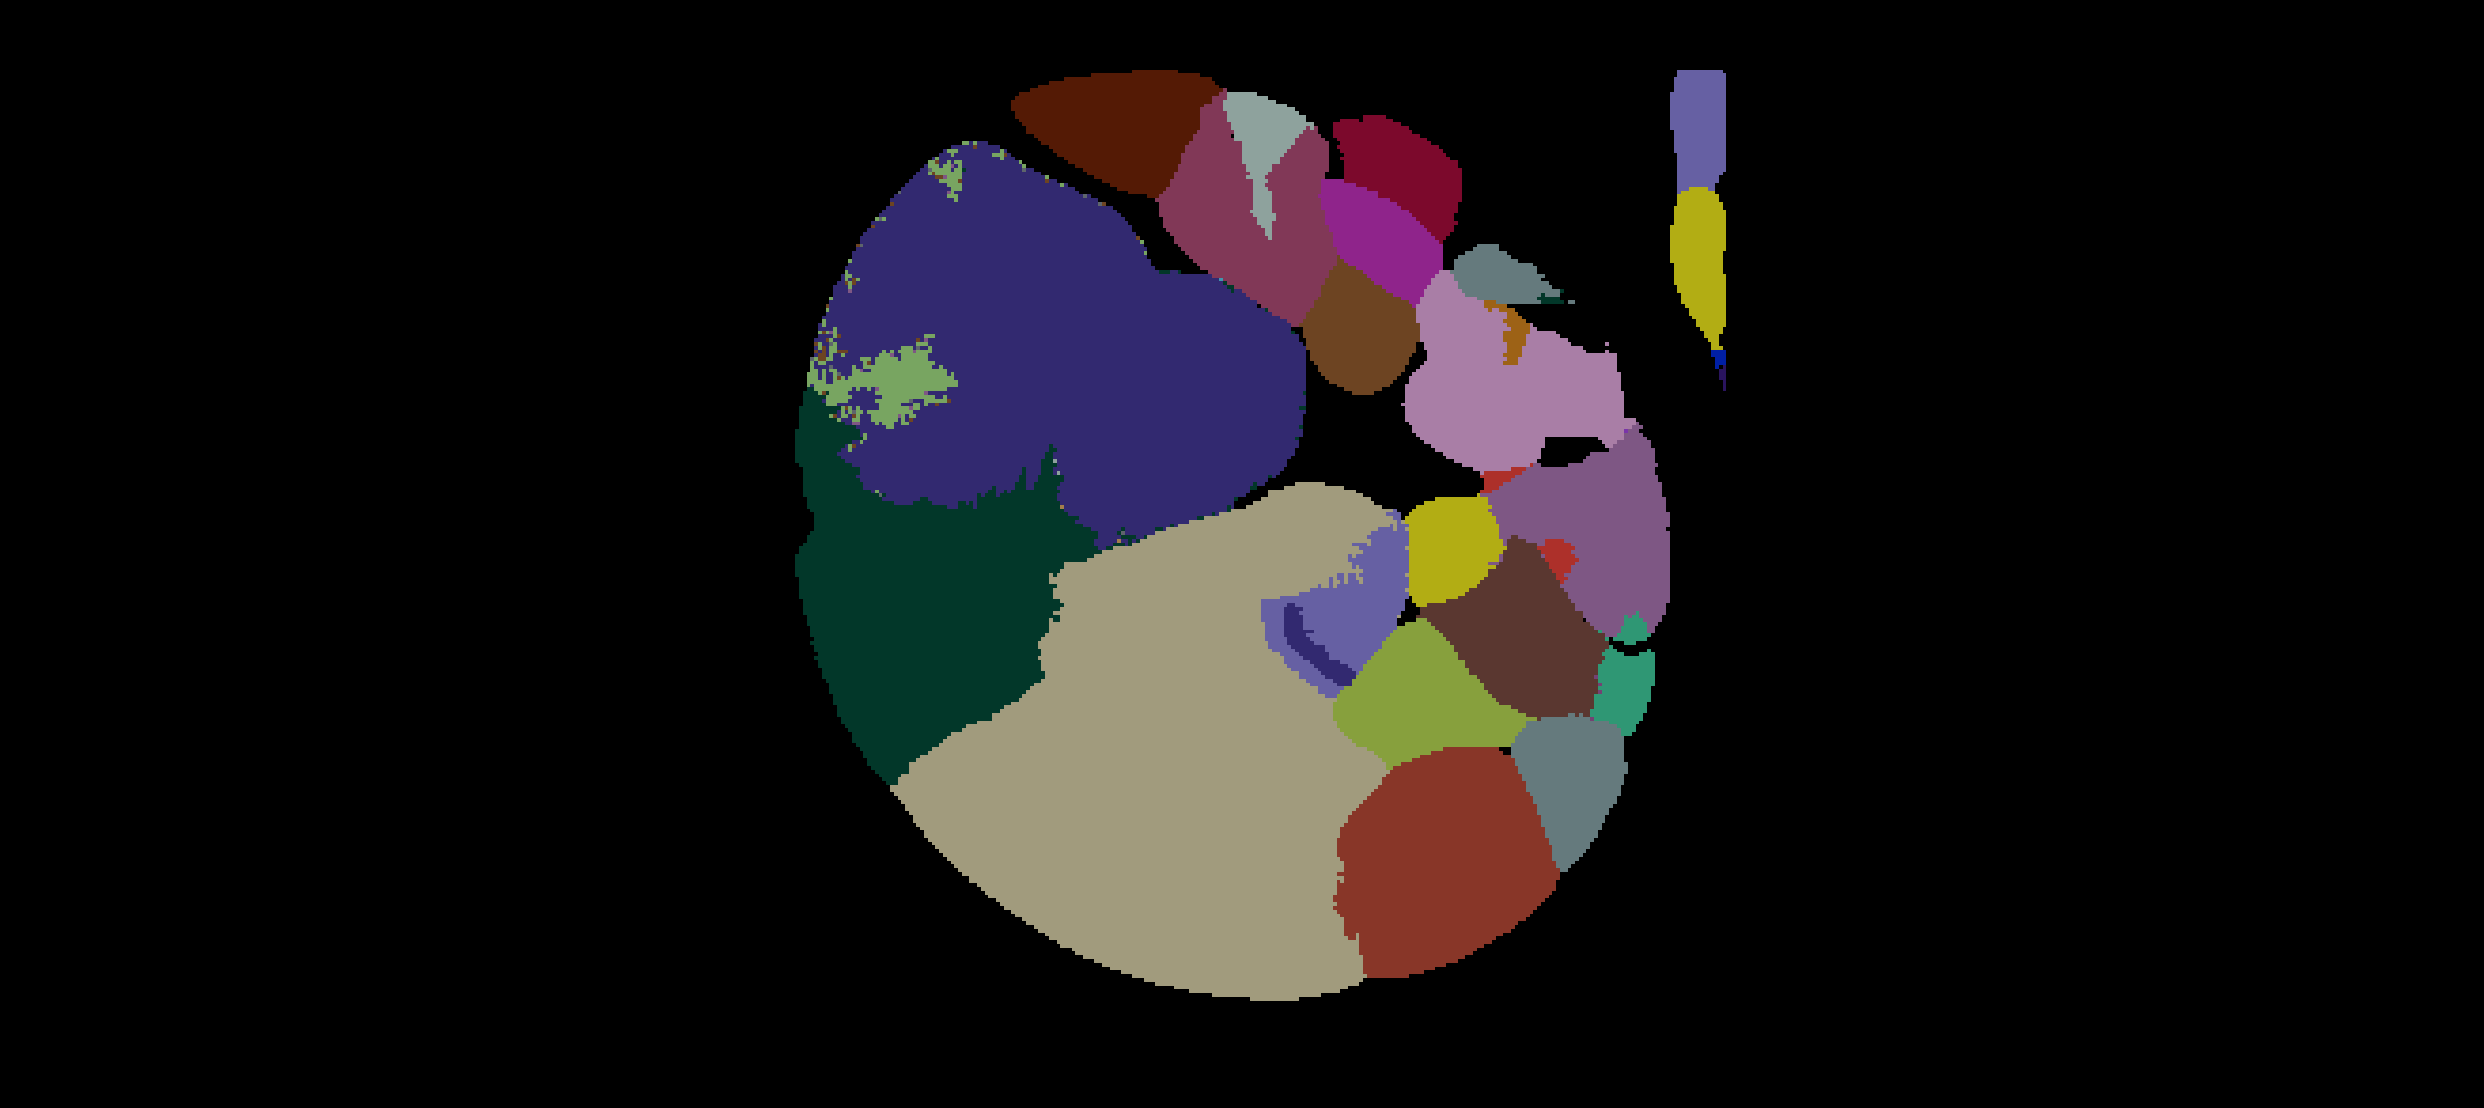

In [7]:
mask = all_masks == 82
print(f'mask shape is {mask.shape}')
viewer.add_labels(mask, name='mask')
nbscreenshot(viewer, canvas_only=True)

### Find the centroid of the mask

#### Solution #1
Use np.where to find the indices of the mask. Then calculate the mean or median of the distribution for each dimension. Add this location as a point.

In [ ]:
coords = np.where(mask == True)
z = np.median(coords[0])
y = np.median(coords[1])
x = np.median(coords[2])
viewer.add_points([(z,y,x)], name='centroid', face_color='green', blending='additive')
nbscreenshot(viewer, canvas_only=True)

#### Solution #2
Use vectorized solution from numpy_indexed (https://stackoverflow.com/questions/36955185/find-center-coordinates-of-regions-in-a-3d-numpy-array) to find either the mean or the median of the mask

In [ ]:
import numpy_indexed as npi
idx = np.indices(mask.shape).reshape(mask.ndim, mask.size)
print(f'idx shape is {idx.shape}')
label, mean = npi.group_by(mask, axis=None).mean(idx, axis=1)
viewer.add_points(mean[:0], name='background', blending='additive')
viewer.add_points(mean[:,-1], name='centroid', face_color='green', blending='additive')
nbscreenshot(viewer, canvas_only=True)
print(mean[:,-1])

In [ ]:
from sklearn.cluster import KMeans

X = np.column_stack((mean[0], mean[1], mean[2]))

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print(kmeans.cluster_centers_)
viewer.add_points(kmeans.cluster_centers_[1], name='k-means_centroid', face_color='pink', blending='additive')
nbscreenshot(viewer, canvas_only=True)

## Filter the cell masks of small shitty regions and the large yolky cells in the vegetal hemisphere

In [5]:
from skimage import morphology

def wipe_layers():
    '''
    Delete all layers in the viewer objected
    '''
    layers = viewer.layers
    while len(layers) > 0:
        layers.remove(layers[0])

def remove_large_objects(labels_array: np.ndarray, max_size: int) -> np.ndarray:
    ''' 
    Remove all objects in a mask above a specific threshold
    '''
    out = np.copy(labels_array)
    component_sizes = np.bincount(labels_array.ravel()) # count the number of pixels in different labels
    too_big = component_sizes > max_size
    too_big_mask = too_big[labels_array]
    out[too_big_mask] = 0
    return out

In [6]:
# remove salt and pepper 'noise' in the regions
salt_and_peppered = morphology.opening(all_masks)
wipe_layers()
viewer.add_labels(salt_and_peppered, name='salt_and_peppered')

# remove small objects
filtered_masks = morphology.remove_small_objects(salt_and_peppered, min_size=15000, connectivity=1)
wipe_layers()
viewer.add_labels(filtered_masks, name='filtered_masks')

# remove large objects
big_filtered = remove_large_objects(filtered_masks, max_size=100000)
wipe_layers()
viewer.add_labels(big_filtered, name='big_filtered')

wipe_layers()
viewer.add_labels(all_masks, name='all_masks')
viewer.add_labels(big_filtered, name = 'filtered masks')

<Labels layer 'filtered masks' at 0x7fc9c0949af0>

In [ ]:
print(np.unique(big_filtered))

### Identify the centroid of each cell mask and add the corresponding points

In [7]:
import numpy_indexed as npi

def find_center_index(labels_array: np.ndarray, center_type: str) -> np.ndarray:
    '''
    Find the center of each 3D label
    Parameters: labels_array - a 2D or 3D label array
    Returns:    
    centroid_labels - a 1D array containing the labels corresponding to each label
    centroids - array containing the index of the center of each label
    '''
    idx = np.indices(labels_array.shape).reshape(labels_array.ndim, labels_array.size)
    if center_type == 'mean':
        centroid_labels, centroids = npi.group_by(labels_array, axis=None).mean(idx, axis=1)
    elif center_type == 'median':
        centroid_labels, centroids = npi.group_by(labels_array, axis=None).median(idx, axis=1)
    else:
        raise ValueError('center_type must be either mean or median')
    return centroid_labels, centroids.T

filt = big_filtered
mean_labels, mean_centroids = find_center_index(filt, 'mean')
median_labels, median_centroids = find_center_index(filt, 'median')

### Load up the nuclei channel and find the centroid of each nucleus

In [9]:
from tifffile import imread
from skimage import measure

nucelei_path = '/Volumes/FlashSSD/220624_Fix_Flvw_Emb_PI_Utr647/220624_Fix_Flvw_Emb_PI_Utr647_E02-10X-Z01_downsample_log_result_1class.tif'
nuclei_img = imread(nucelei_path)
labeled = measure.label(nuclei_img)
nuc_filt = morphology.remove_small_objects(labeled, min_size=5, connectivity=1)
viewer.add_labels(nuc_filt, name='nuc_filt', blending='additive')

nuc_labels, nuc_centroids = find_center_index(nuc_filt, 'median')
viewer.add_points(median_centroids, name='cell centroids (median)', size = 3, face_color='green', blending='additive')
viewer.add_points(nuc_centroids, name='nuc centroids', size=3, face_color='magenta', blending='additive')

<Points layer 'nuc centroids' at 0x7fc9d21562b0>

### Next, for each region, check that the region contains only two points and measure the distance between them

In [10]:

# dictionary containing index of each label as keys and empty list as values
points_dict = {f'{i}' : [iden] for i, iden in enumerate(np.unique(filt))}

# iterate through the labels contained in filt
for ind, label in enumerate(np.unique(filt)):
    mask = filt == label # boolean array
    coords = np.where(mask == True)
    coords = np.column_stack(coords) # ZYX coordinates for every point in the label

    for centroid in median_centroids: # NOTE: mean centroids are floats and must be converted to ints to compare
        #if any(centroid.tolist() == coord.tolist() for coord in coords):
        if any(np.equal(coords, centroid.astype(int)).all(1)):
            points_dict[f'{ind}'].append(centroid)

    for centroid in nuc_centroids:
        if any(np.equal(coords, centroid.astype(int)).all(1)):
            points_dict[f'{ind}'].append(centroid)

labels_to_pop = []
for k, v in points_dict.items():
    if len(v) < 3:
        labels_to_pop.append(k)
        continue
    elif len(v) >3:
        labels_to_pop.append(k)
        continue

for label in labels_to_pop:
    del points_dict[label]

for k,v in points_dict.items():
    print(k, v)

8 [26, array([ 17., 179., 187.]), array([ 18., 182., 188.])]
9 [29, array([  6., 200., 209.]), array([  3., 189., 209.])]
12 [41, array([ 36., 194., 214.]), array([ 36., 183., 206.])]
17 [82, array([ 51., 209., 179.]), array([ 46. , 195.5, 185. ])]
19 [85, array([ 44., 148., 201.]), array([ 45., 145., 201.])]
20 [88, array([ 62.,  38., 123.]), array([ 57.,  37., 127.])]
22 [93, array([ 67.,  63., 157.]), array([ 63.5,  64.5, 160. ])]
23 [96, array([ 64., 123., 208.]), array([ 61., 126., 201.])]
24 [98, array([ 74., 142., 180.]), array([ 64., 142., 182.])]
25 [99, array([ 66., 177., 168.]), array([ 61., 167., 183.])]
26 [103, array([ 85.,  95., 114.]), array([ 76.,  90., 128.])]


### for each label containing two points, calculate the distance between the two points

In [11]:
from scipy import spatial

distance_dict = {}
for k, v in points_dict.items():
    dist = spatial.distance.euclidean(v[0], v[1])
    distance_dict[k] = dist
    viewer.add_shapes(np.array(v[1:]), shape_type='line', name=f'label {v[0]} line', blending='additive')

for k, v in distance_dict.items():
    print(k, v)

8 222.28585200142632
9 249.33912649241395
12 231.0043289637664
17 162.78513445643617
19 138.2244551445221
20 66.34003316248794
22 75.31268153505093
23 119.57006314291216
24 96.1041102138717
25 109.24284873619875
26 22.561028345356956


### Finding the long axis of a cell - first isolate a single mask that looks nice to work with

In [ ]:
mask = all_masks == 82
wipe_layers()
viewer.add_labels(mask, name='mask 82')

In [ ]:
wipe_layers()
# erode the mask to remove the small objects
for i in range(15):
    mask = morphology.erosion(mask)
viewer.add_labels(mask, name='mask 82 eroded')
coords = np.where(mask == True)
z = np.median(coords[0])
y = np.median(coords[1])
x = np.median(coords[2])
viewer.add_points([(z,y,x)], name='centroid', face_color='green', blending='additive')

In [ ]:
from skimage.segmentation import find_boundaries

boundary = find_boundaries(mask)
viewer.add_labels(boundary, name='boundary', blending='additive')

In [ ]:
# find the longest line between two points in the boundary that passes through the centroid
from skimage.segmentation import find_boundaries
from skimage.draw import line


#### my data

In [40]:

coords = np.column_stack(np.where(all_masks == 82))
viewer.add_points(coords, name='coords', size=1, face_color='green', blending='additive')

<Points layer 'coords' at 0x7fc9b18cb100>

In [41]:
# Calculate the mean of the points, i.e. the 'center' of the cloud
datamean = coords.mean(axis=0)
print(datamean)
viewer.add_points([datamean], name='datamean', size=1, face_color='red', blending='additive')

[ 50.71935261 209.35936057 178.09847626]


<Points layer 'datamean' at 0x7fc9b18cbd90>

In [42]:
uu, dd, vv = np.linalg.svd(coords - datamean)

In [47]:
linepts = vv[0] * np.mgrid[-50:50:2j][:, np.newaxis]
# shift by the mean to get the line in the right placeac
linepts += datamean

In [49]:
viewer.add_shapes(linepts, shape_type='line', name='line', blending='additive')

<Shapes layer 'line' at 0x7fc9c1df7490>

In [55]:
np.random.shuffle(coords)
coords.shape
subsampled = coords[::25]
viewer.add_points(subsampled, name='subsampled', size=1, face_color='red', blending='additive')

<Points layer 'subsampled' at 0x7fc9b1303eb0>

In [58]:
subsampled_mean = subsampled.mean(axis=0)
viewer.add_points([subsampled_mean], name='subsampled_mean', size=2, face_color='magenta', blending='additive')


<Points layer 'subsampled_mean' at 0x7fc9c166a460>

In [59]:
uu, dd, vv = np.linalg.svd(subsampled - subsampled_mean)
linepts = vv[0] * np.mgrid[-50:50:2j][:, np.newaxis]
# shift by the mean to get the line in the right placeac
linepts += datamean

In [60]:
viewer.add_shapes(linepts, shape_type='line', name='line', blending='additive')

<Shapes layer 'line [1]' at 0x7fc9b1289040>

#### overflow

In [18]:
# Generate some data that lies along a line

x = np.mgrid[-2:5:120j]
y = np.mgrid[1:9:120j]
z = np.mgrid[-5:3:120j]

type(x)

numpy.ndarray

In [19]:
data = np.concatenate((x[:, np.newaxis], 
                       y[:, np.newaxis], 
                       z[:, np.newaxis]), 
                      axis=1)
data.shape

(120, 3)

In [20]:
wipe_layers()
viewer.add_points(data, name='data', size=1, face_color='green', blending='additive')

<Points layer 'data' at 0x7fca10738520>

In [21]:

# Perturb with some Gaussian noise
data += np.random.normal(size=data.shape) * 0.4
viewer.add_points(data, name='data', size=1, face_color='magenta', blending='additive')

<Points layer 'data [1]' at 0x7fc9c1d95970>

In [24]:
# Calculate the mean of the points, i.e. the 'center' of the cloud
datamean = data.mean(axis=0)
print(datamean)
viewer.add_points([datamean], name='datamean', size=1, face_color='red', blending='additive')

[ 1.63109327  5.00926318 -0.98725021]


<Points layer 'datamean' at 0x7fc990904910>

In [25]:
# Do an SVD on the mean-centered data.
uu, dd, vv = np.linalg.svd(data - datamean)
print(type(uu))
print(uu.shape)
print(type(dd))
print(dd.shape)
print(type(vv))
print(vv.shape)


<class 'numpy.ndarray'>
(120, 120)
<class 'numpy.ndarray'>
(3,)
<class 'numpy.ndarray'>
(3, 3)


In [27]:
print(vv[0])

[[ 0.53147236  0.59531333  0.6026103 ]
 [-0.6146963  -0.21842956  0.75791622]
 [ 0.58282553 -0.77323384  0.24984763]]


In [30]:
linepts = vv[0] * np.mgrid[-7:7:2j][:, np.newaxis]
print(linepts)
# shift by the mean to get the line in the right place
linepts += datamean
print(linepts)

[[-3.72030651 -4.16719331 -4.21827208]
 [ 3.72030651  4.16719331  4.21827208]]
[[-2.08921324  0.84206986 -5.20552229]
 [ 5.35139978  9.17645649  3.23102188]]


In [31]:
viewer.add_shapes(linepts, shape_type='line', name='line', blending='additive')

<Shapes layer 'line' at 0x7fc990ae1dc0>